In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
from pathlib import Path
from collections import defaultdict
from metrics import acc
import itertools
import tqdm
import seaborn as sn
from time import time
import datetime

import scipy
from scipy.signal import find_peaks, savgol_filter
from scipy.fft import fft, ifft, fftfreq
from scipy.io.arff import loadarff
from scipy.optimize import curve_fit

import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from torch.utils.tensorboard import SummaryWriter

#from tsnecuda import TSNE

# import tsfresh
# from tsfresh import extract_relevant_features, extract_features
# from tsfresh.utilities.dataframe_functions import impute
# from tsfresh.feature_selection.significance_tests import target_real_feature_real_test

import numba
from numba import njit

import skorch
from skorch import NeuralNetClassifier

import torch
import torchvision

device = 'cpu'
try:
    if torch.backends.mps.is_available():
        device = 'mps'
except AttributeError:
    device = 'cuda'

print(f"Using '{device}' for model training and inference")

Using 'cuda' for model training and inference


In [55]:
@njit(parallel=True)
def njit_dtw(s1, s2):
    mat_d = np.ones((len(s1) + 1, len(s2) + 1)) * np.Inf
    mat_d[0, 0] = 0
    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            d = (s1[i - 1] - s2[j - 1])**2
            mat_d[i, j] = d + min((mat_d[i-1, j], mat_d[i, j-1], mat_d[i-1, j-1]))
    return np.sqrt(mat_d[len(s1), len(s2)])


def sliding_window(X, y, window_size, step_size):
    X_windows = []
    y_windows = []

    for start_i in range(0, len(X) - window_size, step_size):
        y_unique = np.unique(y[start_i:start_i + window_size])
        if len(y_unique) == 1:
            X_windows.append(X[start_i:start_i + window_size])
            y_windows.append(y_unique[0].split('-')[0])

    X_windows = np.stack(X_windows)
    y_windows = np.asarray(y_windows)
    
    return X_windows, y_windows


def peak_based_segmentation(X, y, window_size, step_size, peak_distance=10):
    X_windows = []
    y_windows = []

    for i in range(step_size, len(X) - window_size, step_size):
        peaks = find_peaks(X[i - step_size:i + step_size], distance=peak_distance)[0]
        selected_peak = np.argmin(np.abs(peaks - step_size))
        window_start = i - step_size + selected_peak
        window = X[window_start:window_start + window_size]
        window_labels = y[window_start:window_start + window_size]
        y_unique = np.unique(window_labels)
        if len(y_unique) == 1:
            X_windows.append(window)
            y_windows.append(y_unique[0].split('-')[0])

    X_windows = np.stack(X_windows)
    y_windows = np.asarray(y_windows)
    
    return X_windows, y_windows


def fft_time_series(X, sampling_rate):
    X_fft = fft(X)
    X_fft[0] = 0.
    X_fft_freq = fftfreq(len(X), 1 / sampling_rate)
    return np.abs(X_fft)[:len(X) // 2]


def fft_based_filtering(X, high_cutoff, sampling_rate):
    frequencies = fftfreq(len(X), 1 / sampling_rate)
    mask = np.abs(frequencies) > high_cutoff
    
    X_fft = fft(X)
    X_fft[mask] = 0.
    X = np.abs(ifft(X_fft))
    
    return X


def savitzky_golay_filtering(X, window_size, degree):
    return savgol_filter(X, window_size, degree)


def shift_mass_to_center(X):
    sinusoid = .5 * (np.cos(np.linspace(-np.pi, np.pi, len(X))) + 1)
    return X * sinusoid


def pca_windows(X, n_components, pca=None):
    if pca is None:
        pca = PCA(n_components=n_components)
        pca.fit(X)
    return pca.transform(X), pca


def resample_time_series(X, new_sampling_rate, original_sampling_rate):
    ratio = new_sampling_rate / original_sampling_rate
    original_size = len(X)
    new_size = int(original_size * ratio)
    x_coord_original = np.arange(0, original_size)
    x_coord_new = np.linspace(0, original_size, new_size)
    X_resampled = np.interp(x_coord_new, x_coord_original, X)
    return X_resampled


def moving_average_smoothing(X, window_size=20):
    X = X.copy()
    return np.convolve(X, np.ones(window_size), 'valid') / window_size


def normalize_time_series(X, symmetric=False):
    x_min, x_max = X.min(), X.max()
    X = X.copy()
    X -= x_min
    X /= (x_max - x_min)
    if symmetric:
        X *= 2
        X -= 1
    return X


def normalize_individual_windows(X):
    min_val, max_val = X.min(), X.max()
    X -= min_val
    X /= (max_val - min_val)
    return X


def standardize_time_series(X):
    x_mean, x_std = X.mean(), X.std()
    X = X.copy()
    X -= x_mean
    X /= x_std
    return X


def balance_dataset(X, y):
    labels, label_counts = np.unique(y, return_counts=True)
    minority_label, minority_count = labels[np.argmin(label_counts)], np.min(label_counts)
    X_sel, y_sel = [], []
    for i, label in enumerate(labels):
        if label != minority_label:
            selected_samples = np.random.choice(label_counts[i], minority_count, replace=False)
            X_sel.append(X[y == label][selected_samples])
            y_sel.append(y[y == label][selected_samples])
        else:
            X_sel.append(X[y == label])
            y_sel.append(y[y == label])
    return np.concatenate(X_sel), np.concatenate(y_sel)


def to_tsfresh_df(X, y):
    full_df = None
    for i, (window, label) in enumerate(zip(X, y)):
        df = pd.DataFrame(window, columns=['norm'])
        df['label'] = label
        df['window_id'] = i
        if full_df is None:
            full_df = df
        else:
            full_df = pd.concat([full_df, df])
            
    full_features = extract_features(full_df.drop('label', axis=1), column_id='window_id', n_jobs=24)
    full_features = impute(full_features)
    
    for feature in full_features.columns:
        mean = full_features[feature].mean()
        std = full_features[feature].std()
        
        full_features[feature] -= mean
        if std != 0.0:
            full_features[feature] /= std
            
    full_features['label'] = full_df[['label', 'window_id']].groupby('window_id').min()['label']
    return full_features        
    
    
def evaluation(X_train, y_train, X_val, y_val, n_classes, method='kmeans'):
    if method == 'kmeans':
        model = KMeans(n_clusters=n_classes, algorithm='elkan')
        model.fit(X_train)
    elif method == 'gmm':
        model = GaussianMixture(n_components=n_classes)
        model.fit(X_train)
    
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    training_acc, mapping = acc(y_train, y_train_pred, return_mapping=True)
    validation_acc = acc(y_val, y_val_pred)
    
    y_train_pred = [mapping[l] for l in y_train_pred]
    y_val_pred = [mapping[l] for l in y_val_pred]
    
    train_acc = accuracy_score(y_train, y_train_pred)
    train_conf_mat = confusion_matrix(y_train, y_train_pred)

    val_acc = accuracy_score(y_val, y_val_pred)
    val_conf_mat = confusion_matrix(y_val, y_val_pred)
    
    return train_acc, val_acc, train_conf_mat, val_conf_mat


def evaluation_with_cv(data_per_horse, n_classes, n_folds=4, n_iter=5, method='kmeans'):
    train_acc = 0.
    val_acc = 0.
    train_conf_mat = np.zeros((n_classes, n_classes))
    val_conf_mat = np.zeros((n_classes, n_classes))
    for i, (train, test) in enumerate(KFold(n_splits=4).split(list(data_per_horse.keys()))):
        training_horses = np.asarray(list(data_per_horse.keys()))[train]
        validation_horses = np.asarray(list(data_per_horse.keys()))[test]
        
        X_train = np.concatenate([data_per_horse[horse][0] for horse in training_horses])
        y_train = np.concatenate([data_per_horse[horse][1] for horse in training_horses])

        X_val = np.concatenate([data_per_horse[horse][0] for horse in validation_horses])
        y_val = np.concatenate([data_per_horse[horse][1] for horse in validation_horses])
        
        for j in range(n_iter):
            print(f"Fold {i}; Iteration {j}")
            train_acc_sub, val_acc_sub, train_conf_mat_sub, val_conf_mat_sub = evaluation(X_train, y_train, X_val, y_val, n_classes=n_classes, method=method)
            train_acc += train_acc_sub
            val_acc += val_acc_sub
            train_conf_mat += train_conf_mat_sub
            val_conf_mat += val_conf_mat_sub
            
    return train_acc / (n_folds * n_iter), val_acc / (n_folds * n_iter), train_conf_mat, val_conf_mat


def plot_results(X_train, y_train, X_val, y_val, encoder=None, clustering_method='kmeans', dec_model=None, device='cuda', n_samples=2_000):
    X_train, y_train = X_train[:n_samples], y_train[:n_samples]
    X_val, y_val = X_val[:n_samples], y_val[:n_samples]
        
    if clustering_method == 'dec':
        y_train_pred = dec_model(torch.from_numpy(X_train).to(torch.float32).to(device)).detach().cpu().numpy()
        y_val_pred = dec_model(torch.from_numpy(X_val).to(torch.float32).to(device)).detach().cpu().numpy()

        y_train_pred = np.argmax(y_train_pred, axis=-1)
        y_val_pred = np.argmax(y_val_pred, axis=-1)

        training_acc, mapping = acc(y_train, y_train_pred, return_mapping=True)
        validation_acc = acc(y_val, y_val_pred)

        y_train_pred = [mapping[l] for l in y_train_pred]
        y_val_pred = [mapping[l] for l in y_val_pred]

        train_acc = accuracy_score(y_train, y_train_pred)
        train_conf_mat = confusion_matrix(y_train, y_train_pred)
        train_conf_mat = train_conf_mat / np.expand_dims(train_conf_mat.sum(axis=1), axis=1)

        val_acc = accuracy_score(y_val, y_val_pred)
        val_conf_mat = confusion_matrix(y_val, y_val_pred)

        val_conf_mat = val_conf_mat / np.expand_dims(val_conf_mat.sum(axis=1), axis=1)
        
        X_train_enc = encoder(torch.from_numpy(X_train).to(torch.float32).to(device)).detach().cpu().numpy()
        X_val_enc = encoder(torch.from_numpy(X_val).to(torch.float32).to(device)).detach().cpu().numpy()
    else:
        if encoder is not None:
            X_train = torch.from_numpy(X_train).to(device).to(torch.float32)
            X_train = encoder(X_train).detach().cpu().numpy()
            X_val = torch.from_numpy(X_val).to(device).to(torch.float32)
            X_val = encoder(X_val).detach().cpu().numpy()
            
        X_train_enc = X_train
        X_val_enc = X_val
    
        train_acc, val_acc, train_conf_mat, val_conf_mat = evaluation(X_train, y_train, X_val
                                                                      , y_val, len(np.unique(y_train)), method=clustering_method)
        train_conf_mat = train_conf_mat / np.expand_dims(train_conf_mat.sum(axis=1), axis=1)
        val_conf_mat = val_conf_mat / np.expand_dims(val_conf_mat.sum(axis=1), axis=1)
        
    X_train_enc = TSNE(perplexity=50, random_state=45).fit_transform(X_train_enc)
    X_val_enc = TSNE(perplexity=50, random_state=45).fit_transform(X_val_enc)
        
    colors = ['r', 'g', 'b', 'gold']
    fig, rows = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    
    ax_l, ax_r = rows[0]
    for label in range(4):
        ax_l.scatter(X_train_enc[y_train == label, 0], X_train_enc[y_train == label, 1], color=colors[label], s=5, alpha=.5)
        ax_r.scatter(X_val_enc[y_val == label, 0], X_val_enc[y_val == label, 1], color=colors[label], s=5, alpha=.5)
        ax_l.set_title('Training', fontsize=20)
        ax_r.set_title('Validation', fontsize=20)
        ax_l.set_xticks([])
        ax_l.set_yticks([])
        ax_r.set_xticks([])
        ax_r.set_yticks([])

    ax_l, ax_r = rows[1]
    cm_train_plot = ConfusionMatrixDisplay(train_conf_mat)
    cm_train_plot.plot(ax=ax_l, colorbar=False)
    cm_val_plot = ConfusionMatrixDisplay(val_conf_mat)
    cm_val_plot.plot(ax=ax_r, colorbar=False)
    
    fig.tight_layout()
    plt.show()

# Neck dataset processing

In [160]:
root_folder = Path('datasets/HorsingAround/data/csv')
movements_of_interest = ('galloping', 'trotting', 'walking', 'standing')
label_mapping = {m: i for i, m in enumerate(movements_of_interest[::-1])}
# label_mapping = defaultdict(lambda: 1)
# label_mapping['standing'] = 0

sampling_rate = 100
window_length = 2 # in seconds
window_size = int(window_length * sampling_rate)
step_size = window_size

normalize = False
normalize_symmetric = False
normalize_windows = True
standardize = False
start_at_peak = False
peak_distance = 50
moving_average_window = None
resampling = False
resampled_sampling_rate = 50
fft_of_windows = True
pca_of_windows = False
pca_n_components = 10
fft_filtering = False
fft_filtering_high_cutoff = 10.
sg_filtering = False
sg_window_size = 25
sg_degree = 2
shift_mass = False
balancing = True
add_noise = False
noise_std = .01

In [88]:
# Get list of the amount of activities per horse
activity_distribution = pd.read_csv(root_folder / 'activity_distribution.csv')
columns_of_interest = []
for movement in movements_of_interest:
    for column in activity_distribution.columns:
        if column.startswith(movement):
            columns_of_interest.append(column)
activity_distribution = activity_distribution[['Row'] + columns_of_interest]

# Filter out the horses that have data on the movements of interest
horses_of_interest = []
for i, row in activity_distribution.iterrows():
    if row['Row'] != 'total':
        movement_counts = defaultdict(float)
        for movement in activity_distribution.columns[1:]:
            movement_type = movement.split('_')[0]
            count = row[movement]
            if count == count:
                movement_counts[movement_type] += row[movement]
        valid = True
        for movement in movements_of_interest:
            if movement_counts[movement] < 1.:
                valid = False
                break
        if valid:
            print(row['Row'], movement_counts, sum(movement_counts.values()))
            horses_of_interest.append(row['Row'])

# Self explanatory            
for i, col in enumerate(columns_of_interest):
    columns_of_interest[i] = col.replace('_', '-')
    
# Get dataframes containing the data of interest as a vector norm
horses_dataframes = []
for horse in horses_of_interest:
    horse_dataframes = []
    for f in root_folder.glob(f'*{horse}*'):
        df = pd.read_csv(f)
        df = df[['label', 'segment', 'Ax', 'Ay', 'Az']].dropna()
        df['norm'] = np.sqrt(df['Ax']**2 + df['Ay']**2 + df['Az']**2)
        if len(df) > 0:
            horse_dataframes.append(df)
    horses_dataframes.append(horse_dataframes)

Galoway defaultdict(<class 'float'>, {'galloping': 1043.0, 'trotting': 6423.0, 'walking': 11055.0}) 18521.0
Bacardi defaultdict(<class 'float'>, {'galloping': 328.0, 'trotting': 1981.0, 'walking': 1677.0}) 3986.0
Driekus defaultdict(<class 'float'>, {'galloping': 323.0, 'trotting': 2673.0, 'walking': 4294.0}) 7290.0
Patron defaultdict(<class 'float'>, {'galloping': 714.0, 'trotting': 3402.0, 'walking': 5538.0}) 9654.0
Happy defaultdict(<class 'float'>, {'galloping': 696.0, 'trotting': 7038.0, 'walking': 9642.0}) 17376.0
Viva defaultdict(<class 'float'>, {'galloping': 82.0, 'trotting': 700.0, 'walking': 1145.0}) 1927.0
Zafir defaultdict(<class 'float'>, {'galloping': 835.0, 'trotting': 3559.0, 'walking': 5239.0}) 9633.0
Sense defaultdict(<class 'float'>, {'galloping': 15.0, 'trotting': 6.0, 'walking': 157.0}) 178.0


/tmp/ipykernel_3249/318028699.py:38: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)
/tmp/ipykernel_3249/318028699.py:38: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)
/tmp/ipykernel_3249/318028699.py:38: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)
/tmp/ipykernel_3249/318028699.py:38: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)
/tmp/ipykernel_3249/318028699.py:38: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)
/tmp/ipykernel_3249/318028699.py:38: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)
/tmp/ipykernel_3249/318028699.py:38: Dty

In [161]:
data_per_horse = {}
for i, horse in enumerate(horses_of_interest):
    dataframes = horses_dataframes[i]
    X_for_horse = []
    y_for_horse = []
    
    for df in dataframes:
        X, y = df.norm.values, df.label.values
        
        if moving_average_window is not None:
            X = moving_average_smoothing(X, window_size=moving_average_window)
        if standardize:
            X = standardize_time_series(X)
        if normalize:
            X = normalize_time_series(X, symmetric=normalize_symmetric)
        if sg_filtering:
            X = savitzky_golay_filtering(X, sg_window_size, sg_degree)
        if fft_filtering:
            X = fft_based_filtering(X, fft_filtering_high_cutoff, sampling_rate)
        
        if start_at_peak:
            X_windows, y_windows = peak_based_segmentation(
                X, y, window_size=window_size, step_size=step_size, peak_distance=peak_distance
            )
        else:
            X_windows, y_windows = sliding_window(
                X, y, window_size=window_size, step_size=step_size
            )
        
        selected_windows = np.isin(y_windows, movements_of_interest)
        X_windows = X_windows[selected_windows]
        y_windows = y_windows[selected_windows]
        y_windows = np.asarray([label_mapping[l] for l in y_windows])
        
        if len(X_windows) > 0:
            if resampling:
                resampled_windows = []
                for window in X_windows:
                    resampled_windows.append(resample_time_series(window, resampled_sampling_rate, sampling_rate))
                X_windows = np.stack(resampled_windows)
            if fft_of_windows:
                transformed_windows = []
                for window in X_windows:
                    transformed_windows.append(fft_time_series(window, sampling_rate))
                X_windows = np.stack(transformed_windows)           
            if shift_mass:
                shifted_windows = []
                for window in X_windows:
                    shifted_windows.append(shift_mass_to_center(window))
                X_windows = np.stack(shifted_windows)
            if normalize_windows:
                X_windows = normalize_individual_windows(X_windows)
            
            X_for_horse.append(X_windows)
            y_for_horse.append(y_windows)
    data_per_horse[horse] = np.concatenate(X_for_horse), np.concatenate(y_for_horse)

In [162]:
training_horses, validation_horses = \
    train_test_split(list(data_per_horse.keys()), train_size=.8, shuffle=True, random_state=765)

X_train = np.concatenate([data_per_horse[horse][0] for horse in training_horses])
y_train = np.concatenate([data_per_horse[horse][1] for horse in training_horses])
if balancing:
    X_train, y_train = balance_dataset(X_train, y_train)
    
X_train, y_train = shuffle(X_train, y_train, random_state=45)

X_val = np.concatenate([data_per_horse[horse][0] for horse in validation_horses])
y_val = np.concatenate([data_per_horse[horse][1] for horse in validation_horses])
X_val, y_val = shuffle(X_val, y_val, random_state=343)

if add_noise:
    X_train += np.random.normal(scale=noise_std, size=X_train.shape)
    X_val += np.random.normal(scale=noise_std, size=X_val.shape)

if pca_of_windows:
    X_train, pca = pca_windows(X_train, n_components=pca_n_components)
    X_val, _ = pca_windows(X_val, n_components=pca_n_components, pca=pca)

y_train.shape, y_val.shape

((6348,), (11086,))

/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


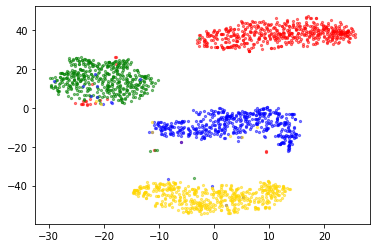

In [117]:
X_enc = TSNE(perplexity=50, random_state=45).fit_transform(X_train[:2000])

colors = ['r', 'g', 'b', 'gold']
for label in range(4):
    plt.scatter(X_enc[y_train[:2000] == label, 0], X_enc[y_train[:2000] == label, 1], color=colors[label], s=5, alpha=.5)
plt.show()

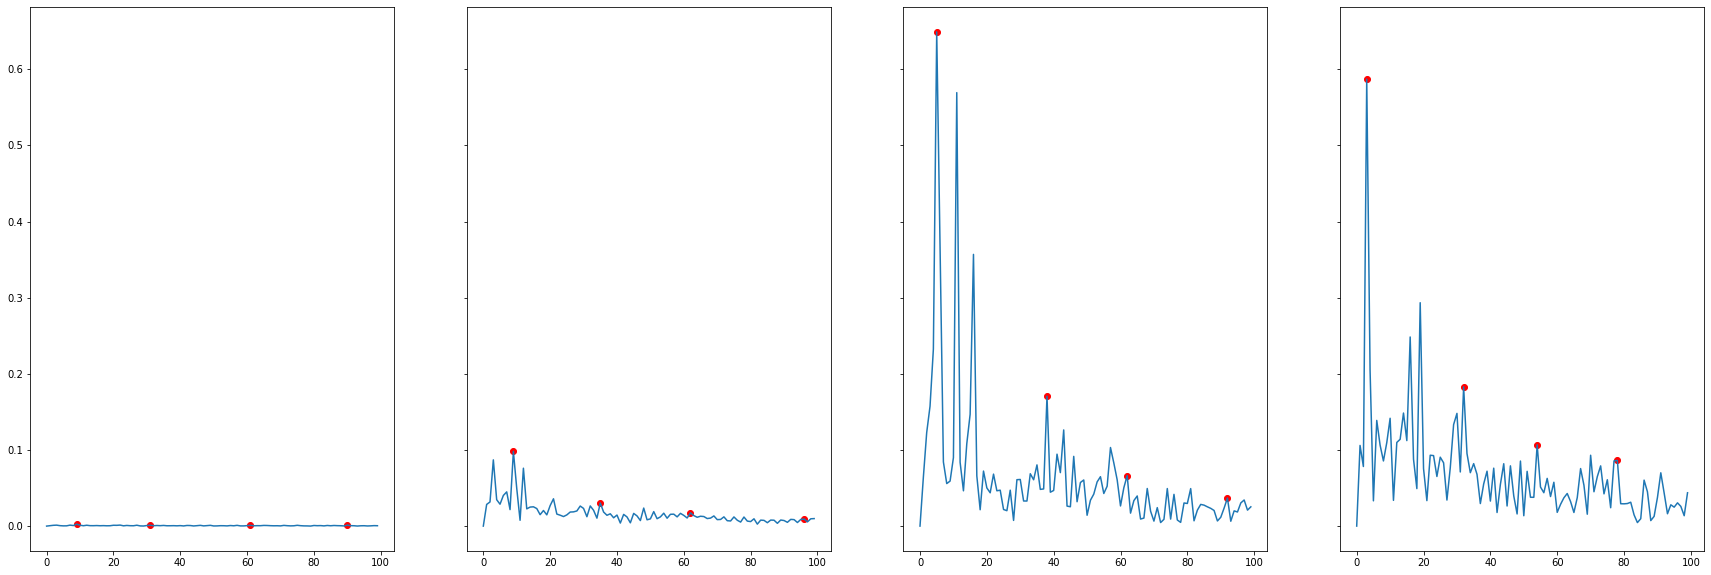

In [118]:
stand_window = X_train[y_train == label_mapping['standing']][0]
stand_peaks = find_peaks(stand_window, distance=20)[0]
walk_window = X_train[y_train == label_mapping['walking']][1]
walk_peaks = find_peaks(walk_window, distance=20)[0]
trot_window = X_train[y_train == label_mapping['trotting']][0]
trot_peaks = find_peaks(trot_window, distance=20)[0]
canter_window = X_train[y_train == label_mapping['galloping']][0]
canter_peaks = find_peaks(canter_window, distance=20)[0]

fig, axs = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(30, 10))
axs[0].plot(stand_window)
axs[0].scatter(stand_peaks, stand_window[stand_peaks], color='r')
axs[1].plot(walk_window)
axs[1].scatter(walk_peaks, walk_window[walk_peaks], color='r')
axs[2].plot(trot_window)
axs[2].scatter(trot_peaks, trot_window[trot_peaks], color='r')
axs[3].plot(canter_window)
axs[3].scatter(canter_peaks, canter_window[canter_peaks], color='r')

plt.show()

In [104]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3]), array([1587, 1587, 1587, 1587]))

# DEC 

In [105]:
class DenseEncoder(torch.nn.Module):
    
    def __init__(self, input_dim, latent_dim,
                 layer_sizes=[512, 128]):
        super(DenseEncoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.layer_sizes = [input_dim] + layer_sizes + [latent_dim]
        
        layers = []
        for i in range(1, len(self.layer_sizes)):
            layers.append(torch.nn.Linear(in_features=self.layer_sizes[i-1], out_features=self.layer_sizes[i]))
            if i != len(self.layer_sizes) - 1:
                layers.append(torch.nn.LeakyReLU(.2))
        self.model = torch.nn.Sequential(*layers)
        
    def forward(self, X):
        return self.model(X)
    
    
class DenseDecoder(torch.nn.Module):
    
    def __init__(self, latent_dim, output_dim,
                 layer_sizes=[128, 512]):
        super(DenseDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        self.layer_sizes = [latent_dim] + layer_sizes + [output_dim]
        
        layers = []
        for i in range(1, len(self.layer_sizes)):
            layers.append(torch.nn.Linear(in_features=self.layer_sizes[i-1], out_features=self.layer_sizes[i]))
            if i != len(self.layer_sizes) - 1:
                layers.append(torch.nn.LeakyReLU(.2))
        self.model = torch.nn.Sequential(*layers)
        
    def forward(self, z):
        return self.model(z)
    
    
class SAELayer(torch.nn.Module):
    
    def __init__(self, input_size, latent_dim, dropout_rate=.2,
                 first_layer=False, last_layer=False):
        super(SAELayer, self).__init__()
        self.input_size = input_size
        self.latent_dim = latent_dim
        self.dropout_rate = dropout_rate
        
        encoder_layers = [
            torch.nn.Dropout(self.dropout_rate),
            torch.nn.Linear(in_features=self.input_size,
                            out_features=self.latent_dim)
        ]
        torch.nn.init.xavier_normal_(encoder_layers[-1].weight)
        if not last_layer:
            encoder_layers.append(torch.nn.ReLU())
        self.encoder = torch.nn.Sequential(*encoder_layers)
        
        decoder_layers = [
            torch.nn.Dropout(self.dropout_rate),
            torch.nn.Linear(in_features=self.latent_dim,
                            out_features=self.input_size)
        ]
        torch.nn.init.xavier_normal_(decoder_layers[-1].weight)
        if not first_layer:
            decoder_layers.append(torch.nn.ReLU())
        self.decoder = torch.nn.Sequential(*decoder_layers)
        
    def encode(self, X):
        return self.encoder(X)
    
    def forward(self, X):
        z = self.encode(X)
        return self.decoder(z)
    
    
class SAE(torch.nn.Module):
    
    def __init__(self, sae_layers, dropout=False):
        super(SAE, self).__init__()
        self.encoder = torch.nn.Sequential(*[l.encoder for l in sae_layers])
        self.decoder = torch.nn.Sequential(*[l.decoder for l in sae_layers[::-1]])
        
        if not dropout:
            [l.eval() for l in self.encoder.modules() if isinstance(l, torch.nn.Dropout)]
            [l.eval() for l in self.decoder.modules() if isinstance(l, torch.nn.Dropout)]
        
    def encode(self, X):
        return self.encoder(X)
    
    def forward(self, X):
        z = self.encode(X)
        return self.decoder(z)
        
    
class ClusteringLayer(torch.nn.Module):
    
    def __init__(self, n_clusters, latent_dim, cluster_centers, alpha=1.0):
        super(ClusteringLayer, self).__init__()
        self.n_clusters = n_clusters
        self.latent_dim = latent_dim
        self.alpha = alpha
        self.cluster_centers = torch.nn.Parameter(cluster_centers)
        #self.dropout = torch.nn.Dropout(.2)
        
    def forward(self, z):
        #z = self.dropout(z)
        squared_norm = torch.sum((z.unsqueeze(1) - self.cluster_centers)**2, 2)
        numerator = (1.0 + squared_norm / self.alpha)**(-(self.alpha + 1) / 2)
        t_dist = (numerator.t() / torch.sum(numerator, 1)).t()
        return t_dist
    
    
class DEC(torch.nn.Module):
    
    def __init__(self, n_clusters, latent_dim, encoder, cluster_centers, alpha=1.0):
        super(DEC, self).__init__()
        self.n_clusters = n_clusters
        self.latent_dim = latent_dim
        self.encoder = encoder
        self.clustering_layer = ClusteringLayer(self.n_clusters, self. latent_dim, cluster_centers, alpha)
        
    def target_distribution(self, q):
        weight = q**2 / torch.sum(q, 0)
        return (weight.t() / torch.sum(weight, 1)).t()
        
    def forward(self, X):
        z = self.encoder(X)
        return self.clustering_layer(z)
    
    def visualize(self, epoch,x):
        fig = plt.figure()
        ax = plt.subplot(111)
        x = self.encoder(x).detach() 
        x = x.cpu().numpy()[:2000]
        x_embedded = TSNE().fit_transform(x)
        plt.scatter(x_embedded[:,0], x_embedded[:,1])
        fig.savefig('own_plots/tsne_{}.png'.format(epoch))
        plt.close(fig)


dense_encoder = DenseEncoder(100, 10)
dense_decoder = DenseDecoder(10, 100)

print(dense_encoder)
print(f"DenseEncoder output: {dense_encoder(torch.randn(64, 100)).size()}")
print(dense_decoder)
print(f"DenseDecoder output: {dense_decoder(torch.randn(64, 10)).size()}")

DenseEncoder(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)
DenseEncoder output: torch.Size([64, 10])
DenseDecoder(
  (model): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=100, bias=True)
  )
)
DenseDecoder output: torch.Size([64, 100])


In [173]:
def pretraining(encoder, decoder,
                X_train, X_val, device='cpu',
                batch_size=128, epochs=50,
                optimizer='adam', lr=1E-3,
                lr_step_size=None, lr_gamma=None, cosine_annealing=False,
                loss_fn='mse', with_noise=False, verbose=True):
    if verbose:
        print(f"Training using device: {device}")
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    
    training_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).to(torch.float32))
    validation_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_val).to(torch.float32))
    
    training_dataloader = torch.utils.data.DataLoader(training_dataset,
                                                      batch_size=batch_size,
                                                      drop_last=True, shuffle=True)
    validation_dataloader = torch.utils.data.DataLoader(validation_dataset,
                                                        batch_size=5_000,
                                                        drop_last=True, shuffle=False)
    
    log_dir = Path(f'logs/pretraining/{datetime.datetime.strftime(datetime.datetime.now(), "%Y%m%d%H%M")}')
    log_dir.mkdir(exist_ok=True, parents=True)
    writer = SummaryWriter(log_dir=log_dir)
    
    if optimizer == 'adam':
        optim = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr, weight_decay=2E-5)
    else:
        optim = torch.optim.SGD(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)
    
    lr_scheduler = None
    if lr_step_size is not None:
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optim,
                                                       step_size=lr_step_size,
                                                       gamma=lr_gamma, verbose=verbose)
    elif cosine_annealing:
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=80, verbose=True)
        
    if loss_fn == 'mse':
        loss_fn = torch.nn.functional.mse_loss
    
    for epoch in range(epochs):
        encoder.train()
        decoder.train()
        
        epoch_training_losses = []
        
        t_train_start = time()
        for X in iter(training_dataloader):
            X = X[0].to(device)
            
            optim.zero_grad()
            if with_noise:
                X_noise = X + torch.randn(X.size()).to(device) * .2
                z = encoder(X_noise)
            else:
                z = encoder(X)
            X_hat = decoder(z)
            loss = loss_fn(X, X_hat)
            loss.backward()
            optim.step()
            
            epoch_training_losses.append(loss.detach().item())
        t_train_end = time()
        
        encoder.eval()
        decoder.eval()
        
        t_eval_start = time()
        X = next(iter(validation_dataloader))[0].to(device)
        z = encoder(X)
        X_hat = decoder(z)
        loss = loss_fn(X, X_hat).detach().item()
        
        fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharex=True, sharey=True)
        for i, rows in enumerate(axs):
            for j, ax in enumerate(rows):
                ax.plot(X[i * 4 + j].detach().cpu().numpy())
                ax.plot(X_hat[i * 4 + j].detach().cpu().numpy())
                ax.set_xticks([])
                ax.set_yticks([])
        fig.tight_layout()
        
        t_eval_end = time()
        
        if lr_scheduler is not None:
            lr_scheduler.step()
            
        writer.add_scalar('Loss/training', np.mean(epoch_training_losses), epoch)
        writer.add_scalar('Loss/validation', loss, epoch)
        writer.add_scalar('Hyperparameters/lr', optim.param_groups[0]['lr'], epoch)
        writer.add_figure('Fig/reconstruction', fig, epoch)
        
        
        if verbose:
            print(f"Epoch {epoch}\nTraining time: {t_train_end - t_train_start:.2f}s; Training loss: {np.mean(epoch_training_losses):.5f};")
            print(f"Validation time: {t_eval_end - t_eval_start:.2f}s; Validation loss: {loss:.5f};")
        
        
def pretraining_sae(X_train, X_val,
                    layer_sizes,
                    device='cpu',
                    batch_size=256,
                    epochs=200, finetune_epochs=400,
                    optimizer='adam', lr=1E-1, lr_decay_it=80, lr_decay_factor=1E-1,
                    loss_fn='mse'):
    sae_layers = []
    X_train_enc = X_train
    X_val_enc = X_val
    for i in range(len(layer_sizes) - 1):
        print(f"Pre-training layer {i} of SAE")
        sae_layer = SAELayer(input_size=layer_sizes[i], latent_dim=layer_sizes[i+1],
                             first_layer=i == 0, last_layer=i != len(layer_sizes) - 2)
        pretraining(sae_layer.encoder, sae_layer.decoder,
                    X_train_enc, X_val_enc,
                    device=device, batch_size=batch_size,
                    epochs=epochs, optimizer=optimizer,
                    lr=lr, lr_step_size=lr_decay_it, lr_gamma=lr_decay_factor, verbose=True)
        X_train_enc = sae_layer.encode(
            torch.from_numpy(X_train_enc).to(device).to(torch.float32)
        ).detach().cpu().numpy()
        X_val_enc = sae_layer.encode(
            torch.from_numpy(X_val_enc).to(device).to(torch.float32)
        ).detach().cpu().numpy()
        sae_layers.append(sae_layer)
    sae = SAE(sae_layers)
    
#     pretraining(sae.encoder, sae.decoder,
#                 X_train, X_val,
#                 device=device, batch_size=batch_size,
#                 epochs=finetune_epochs, optimizer=optimizer,
#                 lr=lr, lr_step_size=lr_decay_it, lr_gamma=lr_decay_factor, verbose=True)
    return sae
    
        
def train_dec(encoder,
              X_train, X_val,
              n_clusters=3, latent_dim=10, tol=1E-3, lr=1E-3,
              noise_factor=.0,
              device='cpu', cluster_init='kmeans'):
    print(f"Training using device: {device}")
    
    encoder = encoder.to(device)
    X_train = torch.from_numpy(X_train).to(torch.float32).to(device)
    X_val = torch.from_numpy(X_val).to(torch.float32).to(device)
    
    # cluster init
    z_train = encoder(X_train)
    if cluster_init == 'kmeans':
        print('Initializing using KMeans!')
        kmeans = KMeans(n_clusters=n_clusters, random_state=86).fit(z_train.detach().cpu())
        cluster_centers = torch.from_numpy(kmeans.cluster_centers_)
        current_cluster_assignment = kmeans.predict(z_train.detach().cpu().numpy())
    elif cluster_init == 'gmm':
        print('Initializing using GMM!')
        gmm = GaussianMixture(n_components=n_clusters, random_state=86).fit(z_train.detach().cpu())
        cluster_centers = torch.from_numpy(gmm.means_)
        current_cluster_assignment = gmm.predict(z_train.detach().cpu().numpy())
    prev_cluster_assignment = np.empty_like(current_cluster_assignment)
    
    dec_model = DEC(n_clusters, latent_dim, encoder, cluster_centers).to(device)
    
    optim = torch.optim.Adam(dec_model.parameters(), lr=lr, weight_decay=1E-3)
    loss_fn = torch.nn.KLDivLoss(reduction='sum')
    
    epoch = 0
    while (current_cluster_assignment != prev_cluster_assignment).sum() / len(current_cluster_assignment) > tol:
        dec_model.train()
        
        t_train_start = time()
            
        output = dec_model(X_train)
        target = dec_model.target_distribution(output).detach()

        loss = loss_fn(output.log(), target) / output.size()[0]
        optim.zero_grad()
        loss.backward()
        optim.step()

        prev_cluster_assignment = current_cluster_assignment
        current_cluster_assignment = np.argmax(output.detach().cpu().numpy(), axis=-1)
        
        t_train_end = time()
        
        dec_model.eval()
        
        t_eval_start = time()
        
        output = dec_model(X_val)
        target = dec_model.target_distribution(output).detach()
        val_loss = loss_fn(output.log(), target) / output.size()[0]
        t_eval_end = time()
        
        print(f"Epoch {epoch};\nTraining time: {t_train_end - t_train_start:.2f}s; Training loss: {loss.detach().item():.5f};")
        print(f"Validation time: {t_eval_end - t_eval_start:.2f}s; Validation loss: {val_loss.detach().item():.5f};")
        print(f"Percentage changed: {(current_cluster_assignment != prev_cluster_assignment).sum() / len(current_cluster_assignment) * 100:.4f}%\n")
        
        epoch += 1
    return dec_model

## KMeans before anything

/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


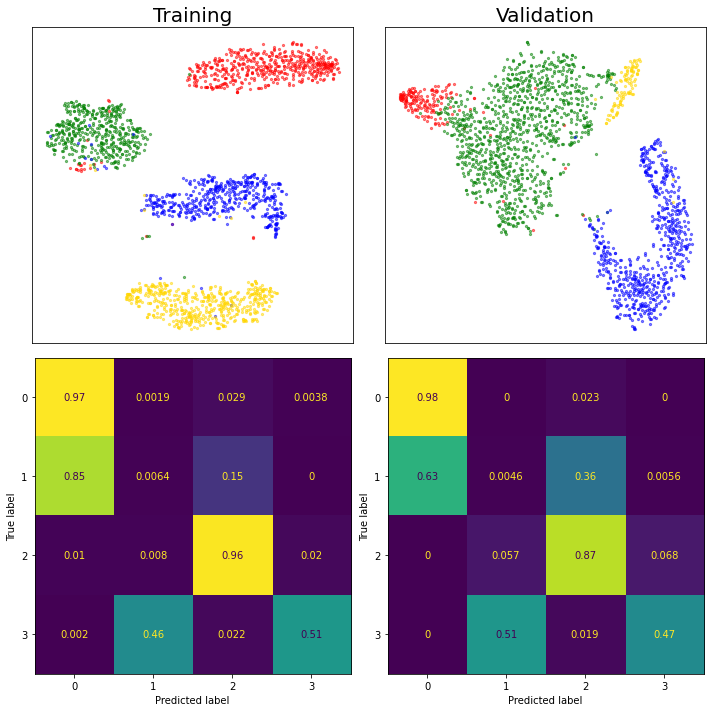

In [119]:
plot_results(X_train, y_train, X_val, y_val, encoder=None, clustering_method='gmm', device=device)

## KMeans after autoencoder

In [121]:
dense_encoder = DenseEncoder(100, 10, layer_sizes=[500, 500])
dense_decoder = DenseDecoder(10, 100, layer_sizes=[500, 500])

pretraining(dense_encoder, dense_decoder,
            X_train, X_val,
            epochs=200, lr=1E-3, batch_size=1024,
            device=device, with_noise=False)

Training using device: cuda
Epoch 0
Training time: 0.02s; Training loss: 0.00550;
Validation time: 0.64s; Validation loss: 0.00266;
Epoch 1
Training time: 0.04s; Training loss: 0.00303;
Validation time: 0.18s; Validation loss: 0.00205;
Epoch 2
Training time: 0.04s; Training loss: 0.00223;
Validation time: 0.18s; Validation loss: 0.00168;
Epoch 3
Training time: 0.04s; Training loss: 0.00209;
Validation time: 0.18s; Validation loss: 0.00157;
Epoch 4
Training time: 0.03s; Training loss: 0.00193;
Validation time: 0.18s; Validation loss: 0.00145;
Epoch 5
Training time: 0.04s; Training loss: 0.00180;
Validation time: 0.18s; Validation loss: 0.00128;
Epoch 6
Training time: 0.04s; Training loss: 0.00163;
Validation time: 0.70s; Validation loss: 0.00120;
Epoch 7
Training time: 0.04s; Training loss: 0.00156;
Validation time: 0.18s; Validation loss: 0.00115;
Epoch 8
Training time: 0.04s; Training loss: 0.00154;
Validation time: 0.18s; Validation loss: 0.00116;
Epoch 9
Training time: 0.04s; Traini

/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


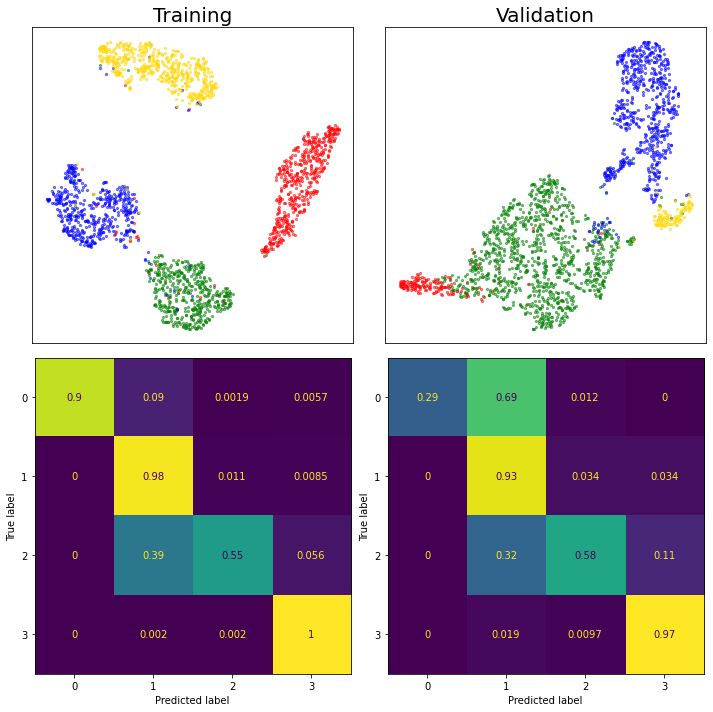

In [122]:
plot_results(X_train, y_train, X_val, y_val, encoder=dense_encoder, clustering_method='gmm', device=device)

In [123]:
model_folder = Path('models/equine')
model_folder.mkdir(exist_ok=True, parents=True)

torch.save(dense_encoder.state_dict(), model_folder / 'encoder')
torch.save(dense_decoder.state_dict(), model_folder / 'decoder')

## KMeans after DEC

In [174]:
model_folder = Path('models/equine')

dense_encoder = DenseEncoder(100, 10, layer_sizes=[500, 500])
dense_decoder = DenseDecoder(10, 100, layer_sizes=[500, 500])

dense_encoder.load_state_dict(torch.load(model_folder / 'encoder'))
dense_decoder.load_state_dict(torch.load(model_folder / 'decoder'))

dec_model = train_dec(dense_encoder, X_train, X_val, n_clusters=len(np.unique(y_train)), device=device, latent_dim=10, lr=1E-2, cluster_init='gmm', tol=1E-3)
dec_model.eval()

Training using device: cuda
Initializing using GMM!
Epoch 0;
Training time: 0.00s; Training loss: 0.04735;
Validation time: 0.00s; Validation loss: 0.01163;
Percentage changed: 24.2754%

Epoch 1;
Training time: 0.00s; Training loss: 0.01681;
Validation time: 0.00s; Validation loss: 0.01965;
Percentage changed: 59.0107%

Epoch 2;
Training time: 0.00s; Training loss: 0.03256;
Validation time: 0.00s; Validation loss: 0.02886;
Percentage changed: 2.8828%

Epoch 3;
Training time: 0.00s; Training loss: 0.03765;
Validation time: 0.00s; Validation loss: 0.03587;
Percentage changed: 5.3875%

Epoch 4;
Training time: 0.00s; Training loss: 0.04018;
Validation time: 0.00s; Validation loss: 0.04353;
Percentage changed: 6.4902%

Epoch 5;
Training time: 0.00s; Training loss: 0.04347;
Validation time: 0.00s; Validation loss: 0.05324;
Percentage changed: 6.9628%

Epoch 6;
Training time: 0.00s; Training loss: 0.04908;
Validation time: 0.00s; Validation loss: 0.06206;
Percentage changed: 7.1676%

Epoch 7;

DEC(
  (encoder): DenseEncoder(
    (model): Sequential(
      (0): Linear(in_features=100, out_features=500, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=500, out_features=500, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=500, out_features=10, bias=True)
    )
  )
  (clustering_layer): ClusteringLayer()
)

/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


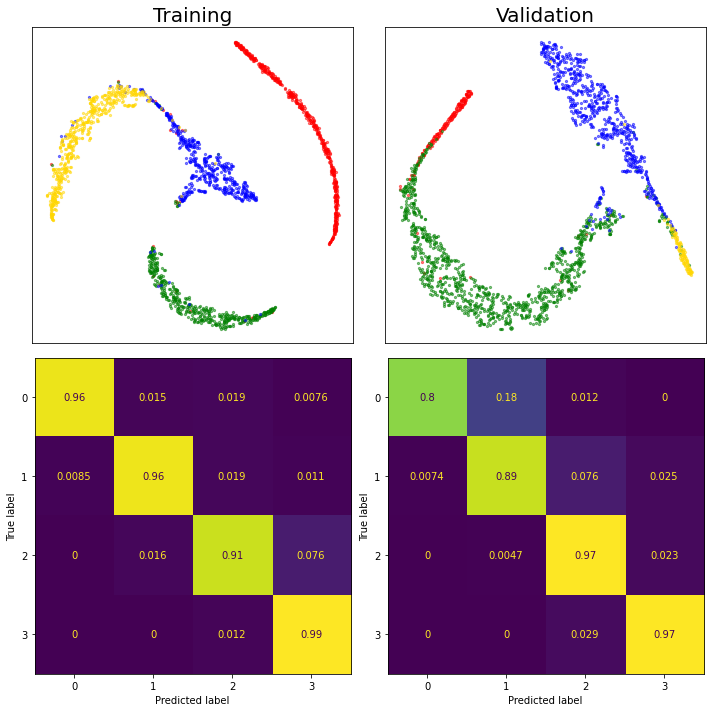

In [172]:
plot_results(X_train, y_train, X_val, y_val, encoder=dense_encoder, clustering_method='dec', dec_model=dec_model, device=device)

## Equine using readily available DEC implementation

In [ ]:
from dec import AutoEncoder, DEC, train, pretrain
# import importlib
# import dec
# importlib.reload(dec)

In [ ]:
autoencoder = AutoEncoder(input_size=X_train.shape[-1]).to(device)
ae_save_path = 'saves/sim_autoencoder.pth'
checkpoint = {
    "epoch": 0,
    "best": float("inf")
}

# X_train = torch.from_numpy(X_train)
# y_train = torch.from_numpy(y_train)

pretrain(data=X_train, model=autoencoder, num_epochs=20, savepath=ae_save_path, checkpoint=checkpoint)

/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


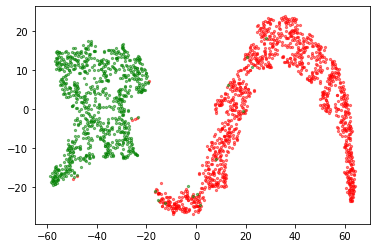

In [47]:
X_enc = TSNE(perplexity=50, random_state=45).fit_transform(autoencoder.encode(torch.from_numpy(X_train[:2000]).to(device).to(torch.float32)).detach().cpu().numpy())

colors = ['r', 'g', 'b']
for label in range(3):
    plt.scatter(X_enc[y_train[:2000] == label, 0], X_enc[y_train[:2000] == label, 1], color=colors[label], s=5, alpha=.5)
plt.show()

In [50]:
dec_save_path='saves/dec.pth'
dec = DEC(n_clusters=len(np.unique(y_train)), autoencoder=autoencoder, hidden=10, cluster_centers=None, alpha=1.0).to(device)

checkpoint = {
    "epoch": 0,
    "best": float("inf")
}
train(data=torch.from_numpy(X_train), labels=torch.from_numpy(y_train), model=dec, n_clusters=len(np.unique(y_train)),num_epochs=20, savepath=dec_save_path, checkpoint=checkpoint)

Initial Accuracy: 0.9661010260457774
Training
plotting


/home/timodw/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Epochs: [0/20] Accuracy:0.9661404893449093, Loss:0.024959273636341095
=> Saving new checkpoint
Epochs: [1/20] Accuracy:0.9670481452249408, Loss:0.02574221044778824
=> Validation Accuracy did not improve
Epochs: [2/20] Accuracy:0.9685477505919495, Loss:0.027248723432421684
=> Validation Accuracy did not improve
Epochs: [3/20] Accuracy:0.9706393054459352, Loss:0.029428556561470032
=> Validation Accuracy did not improve
Epochs: [4/20] Accuracy:0.9723756906077348, Loss:0.03223051875829697
=> Validation Accuracy did not improve
Epochs: [5/20] Accuracy:0.9734806629834254, Loss:0.03557690605521202
=> Validation Accuracy did not improve
Epochs: [6/20] Accuracy:0.9745067087608524, Loss:0.039369769394397736
=> Validation Accuracy did not improve
Epochs: [7/20] Accuracy:0.9740331491712707, Loss:0.04347888380289078
=> Validation Accuracy did not improve
Epochs: [8/20] Accuracy:0.974585635359116, Loss:0.04776293411850929
=> Validation Accuracy did not improve
Epochs: [9/20] Accuracy:0.9745067087608

/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


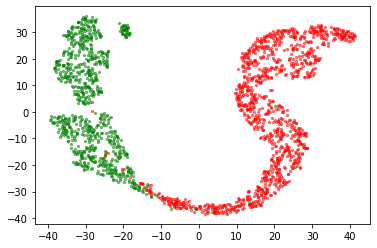

In [52]:
X_enc = TSNE(perplexity=50, random_state=45).fit_transform(autoencoder.encode(torch.from_numpy(X_train[:2000]).to(device).to(torch.float32)).detach().cpu().numpy())

colors = ['r', 'g', 'b']
for label in range(3):
    plt.scatter(X_enc[y_train[:2000] == label, 0], X_enc[y_train[:2000] == label, 1], color=colors[label], s=5, alpha=.5)
plt.show()

## DEC evaluation using MNIST

In [122]:
mnist_train = torchvision.datasets.MNIST(root=Path('datasets/'), train=True, download=True,
                                         transform=torchvision.transforms.Compose([
                                             torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Lambda(torch.flatten)
                                         ]))
mnist_val = torchvision.datasets.MNIST(root=Path('datasets/'), train=False, download=True,
                                       transform=torchvision.transforms.Compose([
                                             torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Lambda(torch.flatten)
                                       ]))

training_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=len(mnist_train))
validation_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=len(mnist_val))
X_train, y_train = next(iter(training_dataloader))
X_val, y_val = next(iter(training_dataloader))

X_train, y_train = X_train.numpy(), y_train.numpy()
X_val, y_val = X_val.numpy(), y_val.numpy()

/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


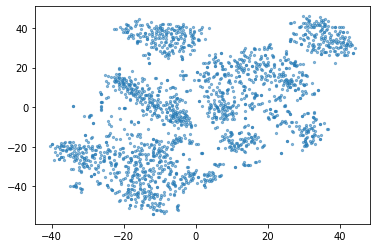

In [123]:
X_enc = TSNE(perplexity=50, random_state=45).fit_transform(X_train[:2000])

plt.scatter(X_enc[:, 0], X_enc[:, 1], s=5, alpha=.5)
plt.show()

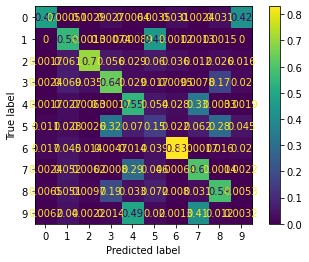

0.5130166666666667

In [124]:
train_acc, val_acc, train_conf_mat, val_conf_mat = evaluation(X_train, y_train, X_val, y_val, 10, method='kmeans')

val_conf_mat = val_conf_mat / np.expand_dims(val_conf_mat.sum(axis=1), axis=1)

cm_plot = ConfusionMatrixDisplay(val_conf_mat)
cm_plot.plot()
plt.show()

val_acc

In [125]:
dense_encoder = DenseEncoder(784, 10, layer_sizes=[500, 500])
dense_decoder = DenseDecoder(10, 784, layer_sizes=[500, 500])

pretraining(dense_encoder, dense_decoder,
            X_train, X_val,
            epochs=20,
            device=device)

Training using device: cuda
Epoch 0
Training time: 0.81s; Training loss: 0.03088;
Validation time: 0.34s; Validation loss: 0.02261;
Epoch 1
Training time: 0.86s; Training loss: 0.02193;
Validation time: 0.19s; Validation loss: 0.02040;
Epoch 2
Training time: 0.85s; Training loss: 0.02055;
Validation time: 0.18s; Validation loss: 0.01958;
Epoch 3
Training time: 0.85s; Training loss: 0.01979;
Validation time: 0.18s; Validation loss: 0.01896;
Epoch 4
Training time: 0.85s; Training loss: 0.01927;
Validation time: 0.39s; Validation loss: 0.01855;
Epoch 5
Training time: 0.86s; Training loss: 0.01889;
Validation time: 0.19s; Validation loss: 0.01813;
Epoch 6
Training time: 0.90s; Training loss: 0.01859;
Validation time: 0.19s; Validation loss: 0.01793;
Epoch 7
Training time: 0.90s; Training loss: 0.01835;
Validation time: 0.19s; Validation loss: 0.01779;
Epoch 8
Training time: 0.90s; Training loss: 0.01818;
Validation time: 0.45s; Validation loss: 0.01755;
Epoch 9
Training time: 0.89s; Traini

/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


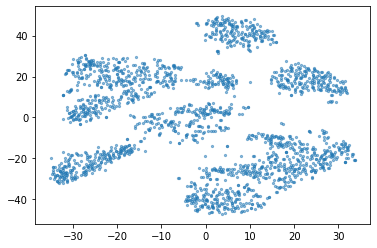

In [127]:
X_enc = TSNE(perplexity=50, random_state=45).fit_transform(dense_encoder(torch.from_numpy(X_train[:2000]).to(device).to(torch.float32)).detach().cpu().numpy())

plt.scatter(X_enc[:, 0], X_enc[:, 1], s=5, alpha=.5)
plt.show()

In [128]:
model_folder = Path('models/mnist')
model_folder.mkdir(exist_ok=True, parents=True)

torch.save(dense_encoder.state_dict(), model_folder / 'encoder')
torch.save(dense_decoder.state_dict(), model_folder / 'decoder')

In [129]:
model_folder = Path('models/mnist')

dense_encoder = DenseEncoder(784, 10, layer_sizes=[500, 500]).to(device)
dense_decoder = DenseDecoder(10, 784, layer_sizes=[500, 500]).to(device)

dense_encoder.load_state_dict(torch.load(model_folder / 'encoder'))
dense_decoder.load_state_dict(torch.load(model_folder / 'decoder'))

<All keys matched successfully>

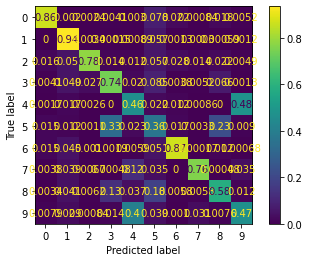

0.6891

In [130]:
z_train = dense_encoder(torch.from_numpy(X_train).to(torch.float32).to(device)).detach().cpu().numpy()
z_val = dense_encoder(torch.from_numpy(X_val).to(torch.float32).to(device)).detach().cpu().numpy()

train_acc, val_acc, train_conf_mat, val_conf_mat = evaluation(z_train, y_train, z_val, y_val, 10, method='kmeans')

val_conf_mat = val_conf_mat / np.expand_dims(val_conf_mat.sum(axis=1), axis=1)

cm_plot = ConfusionMatrixDisplay(val_conf_mat)
cm_plot.plot()
plt.show()

val_acc

In [133]:
model_folder = Path('models/mnist')

dense_encoder = DenseEncoder(784, 10, layer_sizes=[500, 500]).to(device)
dense_decoder = DenseDecoder(10, 784, layer_sizes=[500, 500]).to(device)

dense_encoder.load_state_dict(torch.load(model_folder / 'encoder'))
dense_decoder.load_state_dict(torch.load(model_folder / 'decoder'))

dec_model = train_dec(dense_encoder, X_train, X_val,
                      n_clusters=10, epochs=100,
                      batch_size=len(X_train), device=device, lr=1E-3)

Training using device: cuda
Initializing using KMeans!


/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Epoch 0;
Training time: 0.34s; Training loss: 0.17967;
Validation time: 2.35s; Validation loss: 0.20039;

Epoch 1;
Training time: 0.33s; Training loss: 0.19736;
Validation time: 0.02s; Validation loss: 0.21441;

Epoch 2;
Training time: 0.32s; Training loss: 0.21252;
Validation time: 0.02s; Validation loss: 0.22727;

Epoch 3;
Training time: 0.49s; Training loss: 0.22482;
Validation time: 0.02s; Validation loss: 0.23247;

Epoch 4;
Training time: 0.33s; Training loss: 0.23278;
Validation time: 0.01s; Validation loss: 0.23545;

Epoch 5;
Training time: 0.33s; Training loss: 0.23564;
Validation time: 0.01s; Validation loss: 0.23577;

Epoch 6;
Training time: 0.32s; Training loss: 0.23667;
Validation time: 0.01s; Validation loss: 0.23692;

Epoch 7;
Training time: 0.49s; Training loss: 0.23719;
Validation time: 0.01s; Validation loss: 0.23564;

Epoch 8;
Training time: 0.33s; Training loss: 0.23741;
Validation time: 0.01s; Validation loss: 0.23830;

Epoch 9;
Training time: 0.33s; Training loss: 

/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Epoch 20;
Training time: 0.33s; Training loss: 0.22328;
Validation time: 2.26s; Validation loss: 0.21546;

Epoch 21;
Training time: 0.33s; Training loss: 0.22125;
Validation time: 0.17s; Validation loss: 0.21190;

Epoch 22;
Training time: 0.33s; Training loss: 0.21937;
Validation time: 0.01s; Validation loss: 0.20953;

Epoch 23;
Training time: 0.33s; Training loss: 0.21719;
Validation time: 0.01s; Validation loss: 0.20785;

Epoch 24;
Training time: 0.33s; Training loss: 0.21553;
Validation time: 0.01s; Validation loss: 0.20723;

Epoch 25;
Training time: 0.49s; Training loss: 0.21400;
Validation time: 0.01s; Validation loss: 0.20458;

Epoch 26;
Training time: 0.33s; Training loss: 0.21189;
Validation time: 0.01s; Validation loss: 0.20293;

Epoch 27;
Training time: 0.33s; Training loss: 0.21125;
Validation time: 0.01s; Validation loss: 0.19846;

Epoch 28;
Training time: 0.33s; Training loss: 0.20814;
Validation time: 0.01s; Validation loss: 0.20113;

Epoch 29;
Training time: 0.32s; Train

/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Epoch 40;
Training time: 0.32s; Training loss: 0.19293;
Validation time: 2.25s; Validation loss: 0.18203;

Epoch 41;
Training time: 0.49s; Training loss: 0.18991;
Validation time: 0.01s; Validation loss: 0.18287;

Epoch 42;
Training time: 0.33s; Training loss: 0.19124;
Validation time: 0.01s; Validation loss: 0.17761;

Epoch 43;
Training time: 0.33s; Training loss: 0.18795;
Validation time: 0.01s; Validation loss: 0.18039;

Epoch 44;
Training time: 0.33s; Training loss: 0.18944;
Validation time: 0.01s; Validation loss: 0.17860;

Epoch 45;
Training time: 0.32s; Training loss: 0.18681;
Validation time: 0.01s; Validation loss: 0.17792;

Epoch 46;
Training time: 0.49s; Training loss: 0.18614;
Validation time: 0.01s; Validation loss: 0.17384;

Epoch 47;
Training time: 0.33s; Training loss: 0.18469;
Validation time: 0.01s; Validation loss: 0.17348;

Epoch 48;
Training time: 0.33s; Training loss: 0.18277;
Validation time: 0.01s; Validation loss: 0.17336;

Epoch 49;
Training time: 0.33s; Train

/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Epoch 60;
Training time: 0.33s; Training loss: 0.17254;
Validation time: 2.28s; Validation loss: 0.15957;

Epoch 61;
Training time: 0.50s; Training loss: 0.17163;
Validation time: 0.01s; Validation loss: 0.15832;

Epoch 62;
Training time: 0.34s; Training loss: 0.17098;
Validation time: 0.01s; Validation loss: 0.16015;

Epoch 63;
Training time: 0.33s; Training loss: 0.17201;
Validation time: 0.01s; Validation loss: 0.15860;

Epoch 64;
Training time: 0.33s; Training loss: 0.16903;
Validation time: 0.01s; Validation loss: 0.15824;

Epoch 65;
Training time: 0.33s; Training loss: 0.17284;
Validation time: 0.01s; Validation loss: 0.15507;

Epoch 66;
Training time: 0.33s; Training loss: 0.16731;
Validation time: 0.01s; Validation loss: 0.15878;

Epoch 67;
Training time: 0.32s; Training loss: 0.17033;
Validation time: 0.17s; Validation loss: 0.15518;

Epoch 68;
Training time: 0.34s; Training loss: 0.16620;
Validation time: 0.01s; Validation loss: 0.15514;

Epoch 69;
Training time: 0.33s; Train

/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Epoch 80;
Training time: 0.33s; Training loss: 0.15916;
Validation time: 2.26s; Validation loss: 0.14754;

Epoch 81;
Training time: 0.33s; Training loss: 0.15965;
Validation time: 0.01s; Validation loss: 0.15189;

Epoch 82;
Training time: 0.49s; Training loss: 0.16408;
Validation time: 0.01s; Validation loss: 0.14686;

Epoch 83;
Training time: 0.33s; Training loss: 0.15770;
Validation time: 0.01s; Validation loss: 0.14609;

Epoch 84;
Training time: 0.33s; Training loss: 0.15809;
Validation time: 0.01s; Validation loss: 0.14994;

Epoch 85;
Training time: 0.33s; Training loss: 0.16074;
Validation time: 0.01s; Validation loss: 0.14523;

Epoch 86;
Training time: 0.33s; Training loss: 0.15604;
Validation time: 0.18s; Validation loss: 0.14432;

Epoch 87;
Training time: 0.33s; Training loss: 0.15655;
Validation time: 0.01s; Validation loss: 0.14427;

Epoch 88;
Training time: 0.33s; Training loss: 0.15768;
Validation time: 0.01s; Validation loss: 0.14446;

Epoch 89;
Training time: 0.33s; Train

/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/timodw/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


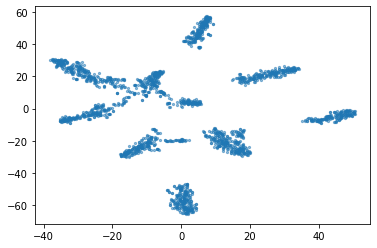

In [134]:
X_enc = TSNE(perplexity=50, random_state=45).fit_transform(dense_encoder(torch.from_numpy(X_train[:2000]).to(device).to(torch.float32)).detach().cpu().numpy())

plt.scatter(X_enc[:, 0], X_enc[:, 1], s=5, alpha=.5)
plt.show()

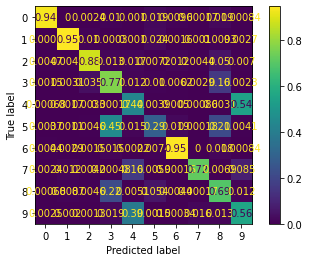

0.72585

In [135]:
y_train_pred = dec_model(torch.from_numpy(X_train).to(torch.float32).to(device)).detach().cpu().numpy()
y_val_pred = dec_model(torch.from_numpy(X_val).to(torch.float32).to(device)).detach().cpu().numpy()

y_train_pred = np.argmax(y_train_pred, axis=-1)
y_val_pred = np.argmax(y_val_pred, axis=-1)

training_acc, mapping = acc(y_train, y_train_pred, return_mapping=True)
validation_acc = acc(y_val, y_val_pred)

y_train_pred = [mapping[l] for l in y_train_pred]
y_val_pred = [mapping[l] for l in y_val_pred]

train_acc = accuracy_score(y_train, y_train_pred)
train_conf_mat = confusion_matrix(y_train, y_train_pred)

val_acc = accuracy_score(y_val, y_val_pred)
val_conf_mat = confusion_matrix(y_val, y_val_pred)

val_conf_mat = val_conf_mat / np.expand_dims(val_conf_mat.sum(axis=1), axis=1)

cm_plot = ConfusionMatrixDisplay(val_conf_mat)
cm_plot.plot()
plt.show()

val_acc

# Least-squares fit

In [64]:
def exponentional_fn(x, a, b, c):
    return a * np.exp(-b * x) + c


def log_fn(x, a, b):
    return a + b * np.log(x)


def quadratic_fn(x, a, b, c):
    return a * x**2 + b * x + c


def calculate_params_of_fit(X, fit_fn, linspace_range=5):
    X_param = []
    for x_sample in X:
        params, _ = curve_fit(fit_fn, xdata=np.linspace(0, linspace_range, len(x_sample)), ydata=x_sample, maxfev=5_000)
        X_param.append(params)
    return np.stack(X_param)

In [71]:
X_train_params = calculate_params_of_fit(X_train, quadratic_fn, linspace_range=10)
X_val_params = calculate_params_of_fit(X_val, quadratic_fn, linspace_range=10)

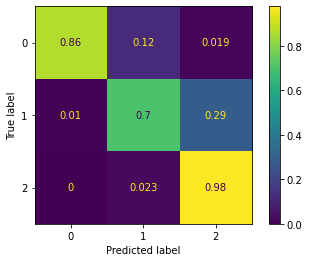

In [74]:
train_acc, val_acc, train_conf_mat, val_conf_mat = evaluation(X_train_params[:, 2:3], y_train, X_val_params[:, 2:3], y_val, len(movements_of_interest), method='kmeans')

val_conf_mat = val_conf_mat / np.expand_dims(val_conf_mat.sum(axis=1), axis=1)

cm_plot = ConfusionMatrixDisplay(val_conf_mat)
cm_plot.plot()
plt.show()

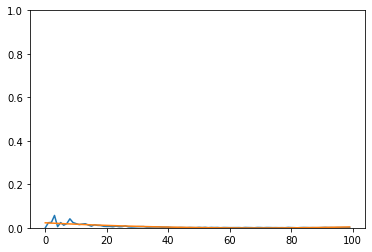

array([ 0.00049947, -0.00689654,  0.02298961])

In [73]:
x_sample = X_train[y_train == 0][0]

fitted_params, _ = curve_fit(quadratic_fn, xdata=np.linspace(0, 10, len(x_sample)), ydata=x_sample)

plt.plot(x_sample)
plt.plot(quadratic_fn(np.linspace(0, 10, len(x_sample)), *fitted_params))
plt.ylim((0, 1))
plt.show()

fitted_params

# Evaluation

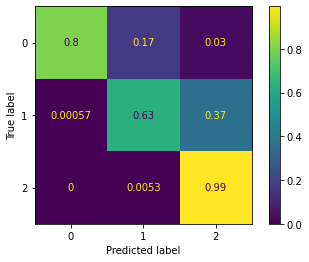

In [18]:
z_train = dense_encoder(torch.from_numpy(X_train).to(torch.float32)).detach().numpy()
z_val = dense_encoder(torch.from_numpy(X_val).to(torch.float32)).detach().numpy()

train_acc, val_acc, train_conf_mat, val_conf_mat = evaluation(z_train, y_train, z_val, y_val, len(movements_of_interest), method='gmm')

val_conf_mat = val_conf_mat / np.expand_dims(val_conf_mat.sum(axis=1), axis=1)

cm_plot = ConfusionMatrixDisplay(val_conf_mat)
cm_plot.plot()
plt.show()

Fold 0; Iteration 0
Fold 0; Iteration 1
Fold 0; Iteration 2
Fold 0; Iteration 3
Fold 0; Iteration 4
Fold 1; Iteration 0
Fold 1; Iteration 1
Fold 1; Iteration 2
Fold 1; Iteration 3
Fold 1; Iteration 4
Fold 2; Iteration 0
Fold 2; Iteration 1
Fold 2; Iteration 2
Fold 2; Iteration 3
Fold 2; Iteration 4
Fold 3; Iteration 0
Fold 3; Iteration 1
Fold 3; Iteration 2
Fold 3; Iteration 3
Fold 3; Iteration 4


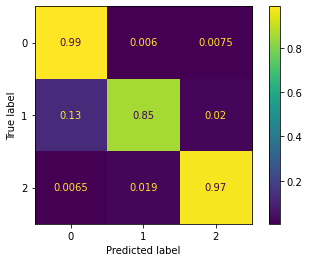

In [19]:
train_acc, val_acc, train_conf_mat, val_conf_mat = evaluation_with_cv(data_per_horse, len(movements_of_interest), method='kmeans')

val_conf_mat = val_conf_mat / np.expand_dims(val_conf_mat.sum(axis=1), axis=1)

cm_plot = ConfusionMatrixDisplay(val_conf_mat)
cm_plot.plot()
plt.show()

Fold 0; Iteration 0
Fold 0; Iteration 1
Fold 0; Iteration 2
Fold 0; Iteration 3
Fold 0; Iteration 4
Fold 1; Iteration 0
Fold 1; Iteration 1
Fold 1; Iteration 2
Fold 1; Iteration 3
Fold 1; Iteration 4
Fold 2; Iteration 0
Fold 2; Iteration 1
Fold 2; Iteration 2
Fold 2; Iteration 3
Fold 2; Iteration 4
Fold 3; Iteration 0
Fold 3; Iteration 1
Fold 3; Iteration 2
Fold 3; Iteration 3
Fold 3; Iteration 4


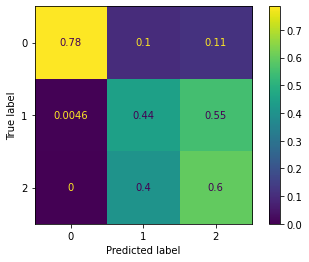

In [20]:
train_acc, val_acc, train_conf_mat, val_conf_mat = evaluation_with_cv(data_per_horse, len(movements_of_interest), method='gmm')

val_conf_mat = val_conf_mat / np.expand_dims(val_conf_mat.sum(axis=1), axis=1)

cm_plot = ConfusionMatrixDisplay(val_conf_mat)
cm_plot.plot()
plt.show()